In [120]:
# ================================
# Step 1: Setup prerequisites
# ================================
import os
import sys
import json
import datetime
from typing import List, Dict, Annotated

from pymongo import MongoClient

# Add parent directory to path to import from utils
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
from utils import track_progress, set_env, create_index, check_index_ready, get_llm

# --- NEW (LTM): imports for long-term memory ---
# MongoDB long-term memory store (langgraph-store-mongodb)
from langgraph.store.mongodb.base import MongoDBStore, VectorIndexConfig  # LTM store
from langchain_voyageai import VoyageAIEmbeddings                        # LTM embeddings
from langmem import create_manage_memory_tool, create_search_memory_tool # LTM tools


In [121]:
# LangGraph core imports
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.mongodb import MongoDBSaver
from langgraph.graph.message import add_messages


# LangChain / tools / LLM plumbing
from langchain.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import ToolMessage
from langchain_core.prompts import ChatPromptTemplate as LCChatPromptTemplate
from pprint import pprint
import voyageai


In [150]:
##EMbeddings test 
from langchain_core.embeddings import Embeddings

class LocalDebugEmbeddings(Embeddings):
    """Minimal embedding class for debugging MongoDBStore vector writes."""

    def embed_documents(self, texts):
        # You can print to see what's being embedded
        print("🔍 embed_documents called with", len(texts), "texts")
        # Return a fixed 1024-dim zero vector for each text
        return [[0.0] * 1024 for _ in texts]

    def embed_query(self, text):
        # Single-vector version for queries
        print("🔍 embed_query called")
        return [0.0] * 1024


In [167]:

# ================================
# MongoDB + environment setup
# ================================

# If you are using your own MongoDB Atlas cluster, use the connection string for your cluster here
MONGODB_URI = os.environ.get("MONGODB_URI")

# Initialize a MongoDB Python client
mongodb_client = MongoClient(MONGODB_URI)

# Check the connection to the server
mongodb_client.admin.command("ping")

# Track progress of key steps-- DO NOT CHANGE
track_progress("cluster_creation", "ai_agents_lab")

# Set the LLM provider and passkey provided by your workshop instructor
# NOTE: LLM_PROVIDER can be set to one of "aws"/ "microsoft" / "google"
LLM_PROVIDER = "aws"
PASSKEY = "NtWY5A"

# Obtain API keys from our AI model proxy and set them as environment variables-- DO NOT CHANGE
set_env([LLM_PROVIDER, "voyageai"], PASSKEY)


# --- NEW (LTM): create MongoDBStore for long-term memory ---

MEMORY_DB_NAME = "mongodb_genai_devday_agents"
MEMORY_COLLECTION_NAME = "agent_memories"

# Get a handle to the long-term memory collection
memory_db = mongodb_client[MEMORY_DB_NAME]
memory_collection = memory_db[MEMORY_COLLECTION_NAME]

# Optional vector index configuration for semantic memory search
memory_index_config = VectorIndexConfig(
    embed=VoyageAIEmbeddings(model="voyage-3"),  # reuse Voyage model
    dims=1024,
    filters= None,                                   # match your doc embedding dims
    fields=["content"],                    # field that holds memory text
)
#Embeddings test
'''memory_index_config = VectorIndexConfig(
    embed=LocalDebugEmbeddings(),   # 👈 swap in the local embedding
    dims=1024,
    fields=None,
    filters=[],
)
'''
# MongoDBStore for long-term, cross-thread memory
memory_store = MongoDBStore(
    collection=memory_collection,
    index_config=memory_index_config,
    #index_config=None,
)


Tracking progress for task cluster_creation
Successfully set AWS_ACCESS_KEY_ID environment variable.
Successfully set AWS_SECRET_ACCESS_KEY environment variable.
Successfully set VOYAGE_API_KEY environment variable.


In [123]:

# ================================
# Step 2: Import data into MongoDB
# ================================

# Do not change the values assigned to the variables below
# Database name
DB_NAME = "mongodb_genai_devday_agents"
# Name of the collection with full documents- used for summarization
FULL_COLLECTION_NAME = "mongodb_docs"
# Name of the collection for vector search- used for Q&A
VS_COLLECTION_NAME = "mongodb_docs_embeddings"
# Name of the vector search index
VS_INDEX_NAME = "vector_index"

# Connect to the `VS_COLLECTION_NAME` collection.
vs_collection = mongodb_client[DB_NAME][VS_COLLECTION_NAME]
# Connect to the `FULL_COLLECTION_NAME` collection.
full_collection = mongodb_client[DB_NAME][FULL_COLLECTION_NAME]

# Insert a dataset of MongoDB docs with embeddings into the `VS_COLLECTION_NAME` collection
with open(f"../data/{VS_COLLECTION_NAME}.json", "r") as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

print(f"Deleting existing documents from the {VS_COLLECTION_NAME} collection.")
vs_collection.delete_many({})
vs_collection.insert_many(data)
print(
    f"{vs_collection.count_documents({})} documents ingested into the {VS_COLLECTION_NAME} collection."
)

# Insert a dataset of MongoDB documentation pages into the `FULL_COLLECTION_NAME` collection
with open(f"../data/{FULL_COLLECTION_NAME}.json", "r") as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

print(f"Deleting existing documents from the {FULL_COLLECTION_NAME} collection.")
full_collection.delete_many({})
full_collection.insert_many(data)
print(
    f"{full_collection.count_documents({})} documents ingested into the {FULL_COLLECTION_NAME} collection."
)


Deleting existing documents from the mongodb_docs_embeddings collection.


101 documents ingested into the mongodb_docs_embeddings collection.
Deleting existing documents from the mongodb_docs collection.
20 documents ingested into the mongodb_docs collection.


In [124]:
# ================================
# Step 3: Create a vector search index
# ================================
# Create vector index definition specifying:
# path: Path to the embeddings field
# numDimensions: Number of embedding dimensions- depends on the embedding model used
# similarity: Similarity metric. One of cosine, euclidean, dotProduct.
model = {
    "name": VS_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 1024,
                "similarity": "cosine",
            }
        ]
    },
}

# Use the `create_index` function from the `utils` module to create a vector search index
create_index(vs_collection, VS_INDEX_NAME, model)

# Use the `check_index_ready` function from the `utils` module to verify that the index was created
check_index_ready(vs_collection, VS_INDEX_NAME)

# Track progress of key steps-- DO NOT CHANGE
track_progress("vs_index_creation", "ai_agents_lab")


Creating the vector_index index
vector_index index status: READY
vector_index index definition: {'fields': [{'type': 'vector', 'path': 'embedding', 'numDimensions': 1024, 'similarity': 'cosine'}]}
Tracking progress for task vs_index_creation


In [125]:
# ================================
# Step 4: Create agent tools
# ================================

# Initialize the Voyage AI client
vo = voyageai.Client()


# -------- Vector Search helper --------
def get_embeddings(query: str) -> List[float]:
    """
    Get embeddings for an input query.

    Args:
        query (str): Query string

    Returns:
        List[float]: Embedding of the query string
    """
    embds_obj = vo.contextualized_embed(inputs=[[query]], model="voyage-context-3", input_type="query")
    # Extract embeddings from the embeddings object
    embeddings = embds_obj.results[0].embeddings[0]
    return embeddings
    return embeddings


@tool
def get_information_for_question_answering(user_query: str) -> str:
    """
    Retrieve information using vector search to answer a user query.

    Args:
    user_query (str): The user's query string.

    Returns:
    str: The retrieved information formatted as a string.
    """

    # Generate embeddings for the `user_query`
    query_embedding = get_embeddings(user_query)

    pipeline = [
        {
            "$vectorSearch": {
                "index": VS_INDEX_NAME,
                "path": "embedding",
                "queryVector": query_embedding,
                "numCandidates": 150,
                "limit": 5,
            }
        },
        {
            "$project": {
                "_id": 0,
                "body": 1,
                "vectorSearchScore": {"$meta": "vectorSearchScore"},
            }
        },
    ]

    results = list(vs_collection.aggregate(pipeline))
    context = "\n\n".join([doc.get("body", "") for doc in results])
    return context


@tool
def get_page_content_for_summarization(user_query: str) -> str:
    """
    Retrieve page content based on provided title.

    Args:
    user_query (str): The user's query string i.e. title of the documentation page.

    Returns:
    str: The content of the page.
    """
    query = {"title": user_query}
    projection = {"_id": 0, "body": 1}
    document = full_collection.find_one(query, projection)

    if document:
        return document["body"]
    else:
        return "Document not found"


In [126]:
from pydantic import BaseModel
class PreferenceMemory(BaseModel):
    category: str
    preference: str
    context: str

In [127]:
# --- NEW (LTM): LangMem tools for long-term memory ---
manage_memory_tool = create_manage_memory_tool(
    namespace="memories",  # user_id comes from graph config
)

search_memory_tool = create_search_memory_tool(
    namespace="memories",
)

In [128]:
# Create the list of tools (doc tools + memory tools)
tools = [
    get_information_for_question_answering,
    get_page_content_for_summarization,
    search_memory_tool,   # long-term memory read
    manage_memory_tool,   # long-term memory write/update/delete
]


In [129]:
# -------- Test tools (optional) --------
get_information_for_question_answering.invoke(
    "What are some best practices for data backups in MongoDB?"
)
get_page_content_for_summarization.invoke("Create a MongoDB Deployment")


"# Create a MongoDB Deployment\n\nYou can create a free tier MongoDB deployment on MongoDB Atlas to store and manage your data. MongoDB Atlas hosts and manages your MongoDB database in the cloud.\n\n## Create a Free MongoDB deployment on Atlas\n\nComplete the Get Started with Atlas guide to set up a new Atlas account and load sample data into a new free tier MongoDB deployment.\n\n## Save your Credentials\n\nAfter you create your database user, save that user's username and password to a safe location for use in an upcoming step.\n\nAfter you complete these steps, you have a new free tier MongoDB deployment on Atlas, database user credentials, and sample data loaded in your database.\n\nIf you run into issues on this step, ask for help in the MongoDB Community Forums or submit feedback by using the Rate this page tab on the right or bottom right side of this page.\n\n"

In [130]:
# ================================
# Step 5: Define graph state
# ================================

# Define the graph state
# We are only tracking chat messages but you can track other attributes as well
class GraphState(TypedDict):
    messages: Annotated[list, add_messages]



In [131]:

# ================================
# Step 6: Instantiate the LLM
# ================================
# Obtain the Langchain LLM object using the `get_llm` function from the `utils` module.
llm = get_llm(LLM_PROVIDER)

# Create a Chain-of-Thought (CoT) prompt template for the agent.
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "You are a helpful AI assistant."
            " You are provided with tools to answer questions and summarize technical documentation related to MongoDB."
            " You ALSO have long-term memory tools that let you store and retrieve important information"
            " across conversations (for example, user roles, preferences, and high-level summaries of work)."
            " Use the memory search tool when prior interactions could help answer the current question"
            " (e.g., 'as we discussed before', 'what did I say about backups?')."
            " Use the memory management tool to store facts such as user role, preferences or compact summaries;"
            " Think step-by-step and use these tools to get the information required to answer the user query."
            " Do not re-run tools unless absolutely necessary."
            " If you are not able to get enough information using the tools, reply with I DON'T KNOW."
            " You have access to the following tools: {tool_names}."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


In [132]:
# Fill in the prompt template with the tool names
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))


In [133]:
# Bind tools to the LLM
bind_tools = llm.bind_tools(tools)

# Chain prompt → tool-augmented LLM
llm_with_tools = prompt | bind_tools


In [134]:
# Test that the LLM is making the right tool calls
llm_with_tools.invoke(
    ["Give me a summary of the page titled Create a MongoDB Deployment."]
).tool_calls



[{'name': 'get_page_content_for_summarization',
  'args': {'user_query': 'Create a MongoDB Deployment'},
  'id': 'toolu_bdrk_01XjybshBqPDHku6uLoADjQ6',
  'type': 'tool_call'}]

In [135]:
llm_with_tools.invoke(
    ["What are some best practices for data backups in MongoDB?"]
).tool_calls


[{'name': 'get_information_for_question_answering',
  'args': {'user_query': 'best practices for data backups in MongoDB'},
  'id': 'toolu_bdrk_01NzCq6juvGWsVbaPRjEGTie',
  'type': 'tool_call'}]

In [136]:
# ================================
# Step 7: Define graph nodes
# ================================
def agent(state: GraphState) -> Dict[str, List]:
    """
    Agent node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    messages = state["messages"]
    result = llm_with_tools.invoke(messages)
    return {"messages": [result]}



In [137]:
# Create a map of tool name to tool object
tools_by_name = {tool.name: tool for tool in tools}
pprint(tools_by_name)


{'get_information_for_question_answering': StructuredTool(name='get_information_for_question_answering', description="Retrieve information using vector search to answer a user query.\n\nArgs:\nuser_query (str): The user's query string.\n\nReturns:\nstr: The retrieved information formatted as a string.", args_schema=<class 'langchain_core.utils.pydantic.get_information_for_question_answering'>, func=<function get_information_for_question_answering at 0x7e1acf8c0ea0>),
 'get_page_content_for_summarization': StructuredTool(name='get_page_content_for_summarization', description="Retrieve page content based on provided title.\n\nArgs:\nuser_query (str): The user's query string i.e. title of the documentation page.\n\nReturns:\nstr: The content of the page.", args_schema=<class 'langchain_core.utils.pydantic.get_page_content_for_summarization'>, func=<function get_page_content_for_summarization at 0x7e1acf8c0a40>),
 'manage_memory': _ToolWithRequired(name='manage_memory', description='Create

In [138]:

def tool_node(state: GraphState) -> Dict[str, List]:
    """
    Tool node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    result: List[ToolMessage] = []
    # Get the list of tool calls from messages (latest AI message)
    tool_calls = state["messages"][-1].tool_calls

    # Iterate through `tool_calls`
    for tool_call in tool_calls:
        tool_obj = tools_by_name[tool_call["name"]]
        observation = tool_obj.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))

    return {"messages": result}


In [139]:

# ================================
# Step 8: Define conditional edges
# ================================
def route_tools(state: GraphState):
    """
    Use in the conditional_edge to route to the tool node if the last message
    has tool calls. Otherwise, route to the end.
    """
    messages = state.get("messages", [])
    if len(messages) == 0:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    ai_message = messages[-1]

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


In [140]:
# ================================
# Step 9: Build the graph
# ================================
from IPython.display import display

# Instantiate the graph
graph = StateGraph(GraphState)

graph.add_node("agent", agent)
graph.add_node("tools", tool_node)

graph.add_edge(START, "agent")
graph.add_edge("tools", "agent")

graph.add_conditional_edges(
    "agent",
    route_tools,
    {
        "tools": "tools",
        END: END,
    },
)


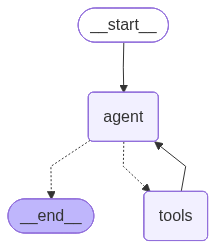

In [141]:
# Compile the graph initially (we’ll recompile with checkpointer + store later)
app = graph.compile(store=memory_store)  # long-term semantic memory for LangMem tools

# Visualize the graph (optional in notebooks)
display(app)


In [142]:

# ================================
# Step 10: Execute the graph (no ST memory)
# ================================
def execute_graph(user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        user_input (str): User query string
    """
    for step in app.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        stream_mode="values",
    ):
        step["messages"][-1].pretty_print()


In [143]:
# Example test runs
execute_graph("What are some best practices for data backups in MongoDB?")
execute_graph("Give me a summary of the page titled Create a MongoDB Deployment")



================================ Human Message =================================

What are some best practices for data backups in MongoDB?
================================== Ai Message ==================================

I'll help you find information about best practices for data backups in MongoDB.
Tool Calls:
  get_information_for_question_answering (toolu_bdrk_01Qss8wboAiaTpHXjLcs2jTz)
 Call ID: toolu_bdrk_01Qss8wboAiaTpHXjLcs2jTz
  Args:
    user_query: best practices for data backups in MongoDB
================================= Tool Message =================================

# Backup and Restore Sharded Clusters

The following tutorials describe backup and restoration for sharded clusters:

To use `mongodump` and `mongorestore` as a backup strategy for sharded clusters, you must stop the sharded cluster balancer and use the `fsync` command or the `db.fsyncLock()` method on `mongos` to block writes on the cluster during backups.

Sharded clusters can also use one of the following

In [144]:
# ================================
# Step 11: Add short-term memory (checkpointer)
# ================================
# Initialize a MongoDB checkpointer (short-term/thread memory)
checkpointer = MongoDBSaver(
    mongodb_client,
    db_name=DB_NAME,
    collection_name="agent_checkpoints",
)

In [145]:

# Instantiate the graph with the checkpointer AND the long-term store
app = graph.compile(
    checkpointer=checkpointer,  # short-term/thread memory
    store=memory_store,         # long-term semantic memory for LangMem tools
)


In [146]:
from langchain_core.messages import AIMessage, ToolMessage

def execute_graph_with_memory(thread_id: str, user_input: str) -> None:
    config = {
        "configurable": {
            "thread_id": thread_id,
            "user_id": "devday-demo-user",
        }
    }

    for step in app.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    ):
        msg = step["messages"][-1]

        # ✅ Print tool calls if this is an AI message
        if isinstance(msg, AIMessage) and msg.tool_calls:
            print("\n🔧 TOOL CALLS:")
            for tc in msg.tool_calls:
                print(f" - tool: {tc['name']}")
                print(f"   args: {tc['args']}")

        # ✅ Print tool execution results
        if isinstance(msg, ToolMessage):
            print("\n📦 TOOL RESULT:")
            print(msg.content)

        # ✅ Print the message itself
        msg.pretty_print()



In [147]:

# Test graph execution with thread ID (short-term + long-term memory)
execute_graph_with_memory(
    "y",
    "I am a DBA and I focus on Data recovery. What are some best practices for data backups in MongoDB?",
)


================================ Human Message =================================

I am a DBA and I focus on Data recovery. What are some best practices for data backups in MongoDB?

🔧 TOOL CALLS:
 - tool: get_information_for_question_answering
   args: {'user_query': 'best practices for data backups in MongoDB'}
 - tool: manage_memory
   args: {'action': 'create', 'content': 'User is a DBA (Database Administrator) with a focus on data recovery'}
================================== Ai Message ==================================

I'll help you find best practices for data backups in MongoDB. Let me search for this information and also save your role for future reference.
Tool Calls:
  get_information_for_question_answering (toolu_bdrk_01VA5CsGvyMETr1scT9TwhbU)
 Call ID: toolu_bdrk_01VA5CsGvyMETr1scT9TwhbU
  Args:
    user_query: best practices for data backups in MongoDB
  manage_memory (toolu_bdrk_018LYqEzhNu2ZxtRFGKzr3xa)
 Call ID: toolu_bdrk_018LYqEzhNu2ZxtRFGKzr3xa
  Args:
    action: 

IndexError: list index out of range

In [ ]:

# Follow-up question to ensure message history works
execute_graph_with_memory(
    "1",
    "What did I just ask you?",
)


================================ Human Message =================================

What did I just ask you?
================================== Ai Message ==================================

You just asked me: "What are some best practices for data backups in MongoDB?"


In [ ]:
'''execute_graph_with_memory(
    "2",
    "What did I say about backups?",
)'''

================================ Human Message =================================

What did I say about backups?

🔧 TOOL CALLS:
 - tool: search_memory
   args: {'query': 'backups'}
================================== Ai Message ==================================
Tool Calls:
  search_memory (toolu_bdrk_01NiNLmtQ13i6kxb81bA5Bpj)
 Call ID: toolu_bdrk_01NiNLmtQ13i6kxb81bA5Bpj
  Args:
    query: backups

📦 TOOL RESULT:
[]
================================= Tool Message =================================

[]
================================== Ai Message ==================================

You haven't said anything about backups in our previous conversations. This is the first time we've discussed backups - you asked me about best practices for data backups in MongoDB, and I provided information based on the MongoDB documentation. 

Is there something specific about backups you'd like to discuss or have me remember for future reference?


In [168]:
# 🔍 DEBUG: Write one memory via MongoDBStore and inspect the raw document

from pprint import pprint

# 1️⃣ Define a test namespace/key/value
#    Match the namespace LangMem uses: ("memories", user_id)
test_namespace = ("memories", "devday-demo-user")  # adjust if your user_id is different
test_key = "debug_test_memory"
test_content = "User is a DBA focused on data recovery (debug test memory)."

test_value = {
    "content": test_content,
    "type": "debug_memory",
}

print("➡️ Calling memory_store.put(...)")
memory_store.put(
    namespace=test_namespace,
    key=test_key,
    value=test_value,
    
)

# 2️⃣ Fetch the raw document from MongoDB
print("\n➡️ Reading back from MongoDB (raw document):")
doc = memory_collection.find_one({"value.content": test_content})
if not doc:
    print("❌ No document found with that content. Check collection name / namespace.")
else:
    pprint(doc)

    # 3️⃣ Inspect the embedding field (if vector index is configured)
    embedding = doc.get("embedding") or doc.get("vector") or doc.get("value", {}).get("embedding")
    if embedding is None:
        print("\n⚠️ No embedding field found on this document.")
        print("   That likely means index_config.embed is not wired or this store is running in KV-only mode.")
    else:
        print("\n✅ Found embedding on the document:")
        try:
            print("   Type:", type(embedding))
            print("   Length:", len(embedding))
        except TypeError:
            print("   (embedding is not a simple list; raw value below)")
            pprint(embedding)


➡️ Calling memory_store.put(...)

➡️ Reading back from MongoDB (raw document):
{'_id': ObjectId('6938d1846da316c66eb1076d'),
 'created_at': datetime.datetime(2025, 12, 10, 1, 48, 52, 83000),
 'embedding': [-0.013823331333696842,
               -0.062448929995298386,
               0.0364285446703434,
               -0.012197056785225868,
               0.03707905113697052,
               0.05073975771665573,
               0.005407361779361963,
               -0.030899209901690483,
               -0.004573896527290344,
               0.09302288293838501,
               0.02748403511941433,
               0.011627860367298126,
               -0.07773590832948685,
               0.008293998427689075,
               -0.036265917122364044,
               0.017726389691233635,
               -0.020328428596258163,
               0.024719368666410446,
               0.018783466890454292,
               0.017482448369264603,
               0.03236285597085953,
               0.009757645428180